In [1]:
!pip3 install numpy pandas matplotlib
import os
import numpy as np
import pandas as pd
import re

In [2]:
if 'TIRA_DATASET_ID' not in os.environ:
    !pip3 install python-terrier tira==0.0.88
else:
    print('We are in the TIRA sandbox.')

In [3]:
from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run

# this loads and starts pyterrier so that it also works in the TIRA
ensure_pyterrier_is_loaded()

# PyTerrier must be imported after the call to ensure_pyterrier_is_loaded in TIRA.
import pyterrier as pt

/Users/dominicwild/anaconda3/envs/IR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Due to execution in TIRA, I have patched ir_datasets to always return the single input dataset mounted to the sandbox.
Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.10.0 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


### Herausfinden des Schwellwerts

In [4]:
df = pd.read_xml("topics-anonymized.xml")
df.head()

,number,title,description,narrative
0,1,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...
1,2,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe..."
2,3,flights Frankfurt to Rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...
3,4,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...
4,5,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...


In [5]:
df["length"] = df["title"].map(lambda x: len(x))
df["word_count"] = df["title"].map(lambda x: x.count(" ")+1)
df.head()

,number,title,description,narrative,length,word_count
0,1,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...,71,12
1,2,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe...",27,4
2,3,flights Frankfurt to Rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...,25,4
3,4,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...,18,3
4,5,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...,13,3


array([[<Axes: title={'center': 'length'}>]], dtype=object)

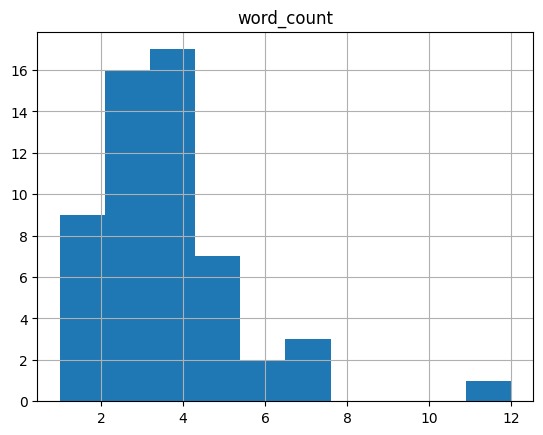

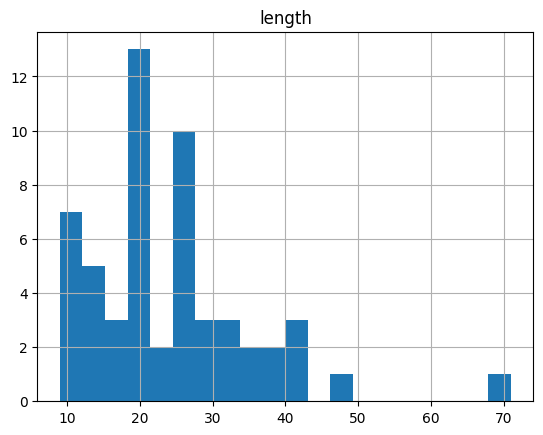

In [6]:
df.hist(column="word_count")
df.hist(column="length", bins=20)

In [12]:
median = df["word_count"].median()
groups_df = pd.DataFrame({f"median = {median}": ["below", "above"], 
                           "# topics with median not included": [len(df[df["word_count"] < median]), len(df[df["word_count"] > median])], 
                           "# topics with median included": [len(df[df["word_count"] <= median]), len(df[df["word_count"] >= median])]})
groups_df = groups_df.style.highlight_max("# topics with median not included", props="font-weight: bold").highlight_min("# topics with median included", props="font-weight: bold")
groups_df

,median = 4.0,# topics with median not included,# topics with median included
0,below,25,42
1,above,13,30


### Index bauen

In [13]:
data = pt.get_dataset('irds:ir-lab-jena-leipzig-wise-2023/validation-20231104-training')

Load ir_dataset "ir-lab-jena-leipzig-wise-2023/validation-20231104-training" from tira.


In [14]:
print('Build index:')
iter_indexer = pt.IterDictIndexer("/tmp/index", meta={'docno': 100}, verbose=True)
!rm -Rf /tmp/index
indexref = iter_indexer.index(data.get_corpus_iter())
print('Done. Index is created')

Build index:
No settings given in /Users/dominicwild/.tira/.tira-settings.json. I will use defaults.
No settings given in /Users/dominicwild/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents:   0%|          | 0/61307 [00:00<?, ?it/s]

No settings given in /Users/dominicwild/.tira/.tira-settings.json. I will use defaults.
No settings given in /Users/dominicwild/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents: 100%|██████████| 61307/61307 [00:25<00:00, 2444.66it/s]


Done. Index is created


### Unsere Retrieval Pipeline

In [92]:
expansion_model = pt.rewrite.Bo1QueryExpansion(indexref, verbose=True)
retrieval_model = pt.BatchRetrieve(indexref, wmodel="TF_IDF", verbose=True)
qe_pipeline = ~(retrieval_model >> expansion_model >> retrieval_model)
non_qe_pipeline = ~retrieval_model

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


Transformer: 100%|██████████| 882/882 [00:01<00:00, 675.22q/s]


In [120]:
# let's have a look at the transformed queries
transformed_queries = expansion_model.transform(data.get_qrels().merge(data.get_topics(), on="qid").head(100))
print("-"*10)
for index in range(0, 5):
    print(f"original query: {transformed_queries['query_0'].iloc[index]}")
    print(f"transformed query: {transformed_queries['query'].iloc[index]}")
    print("-"*10)

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


Transformer: 100%|██████████| 7/7 [00:00<00:00, 126.77q/s]

----------
original query: purchase money
transformed query: applypipeline:off purchas^1.000000000 monei^1.000000000 gold^0.306042586 lingot^0.226625605 preciou^0.226080861 ingot^0.129503827 coin^0.126064226 silver^0.121320318 metal^0.104846959 bui^0.102264392 jewelleri^0.098045357 diamond^0.086956339
----------
original query: purchase used car
transformed query: applypipeline:off purchas^1.134600290 car^1.000000000 option^0.206735936 guarante^0.100144691 0km^0.084918200 mileag^0.083004202 km^0.065027410 00^0.064852639 cost^0.061966056 benefit^0.059924105 loa^0.055351310
----------
original query: buy gold silver
transformed query: applypipeline:off bui^1.000000000 gold^1.332435879 silver^1.115348013 preciou^0.113793837 coin^0.107980253 currenc^0.097586931 metal^0.072309372 ingot^0.061639337 invest^0.059505354 exchang^0.049419851 bullion^0.045143594
----------
original query: adenovirus
transformed query: applypipeline:off adenoviru^1.130162672 sinus^0.825056494 vaccin^0.290193162 ade

In [95]:
topics = data.get_topics()
topics.head()

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


,qid,text,title,query,description,narrative
0,q072224,purchase money,purchase money,purchase money,None,None
1,q072226,purchase used car,purchase used car,purchase used car,None,None
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None
3,q072240,adenovirus,adenovirus,adenovirus,None,None
4,q072242,Water softener,Water softener,water softener,None,None


In [96]:
# Calculation of the number of words in the title
topics["word_count_old"] = topics["title"].map(lambda x: x.count(" ")+1)
# Calculation of the number of characters in the title
topics["length"] = topics["title"].map(lambda x: len(x))

# Calculation of the number of words in the title using the pyterrier tokenizer
# https://pyterrier.readthedocs.io/en/latest/text.html#working-with-passages-rather-than-documents : r'\s+' instead of ' '
topics["word_count"] = topics["title"].map(lambda x: len(re.split(r'\s+', x)))

topics.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count
0,q072224,purchase money,purchase money,purchase money,None,None,2,14,2
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,17,3
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,15,3
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,10,1
4,q072242,Water softener,Water softener,water softener,None,None,2,14,2


In [97]:
# Calulation of the Threshold
topics["word_count"] = topics["title"].map(lambda x: x.count(" ")+1)
threshold = topics["word_count"].median()
if len(topics[topics["word_count"] > threshold]) > len(topics[topics["word_count"] < threshold]):
    topics["is_long"] = topics["word_count"] > threshold
else:
    topics["is_long"] = topics["word_count"] >= threshold

In [98]:
# Experiment over all topics and the two pipelines
experiment = pt.Experiment(
    [qe_pipeline, non_qe_pipeline],
    topics, data.get_qrels(),
    ["ndcg_cut_5"],
    ["mit QE", "ohne QE"],
    perquery=True
)

BR(TF_IDF): 100%|██████████| 878/878 [00:11<00:00, 76.44q/s]


In [99]:
# merge the topics with the results
eval_all = experiment.merge(topics, on="qid")
eval_all.head()

,name,qid,measure,value,text,title,query,description,narrative,word_count_old,length,word_count,is_long
0,mit QE,q072210025,ndcg_cut_5,0.0,recipe spring roll,recipe spring roll,recipe spring roll,None,None,3,18,3,True
1,ohne QE,q072210025,ndcg_cut_5,0.0,recipe spring roll,recipe spring roll,recipe spring roll,None,None,3,18,3,True
2,mit QE,q072210054,ndcg_cut_5,0.0,chateaux relays,chateaux relays,chateaux relays,None,None,2,15,2,False
3,ohne QE,q072210054,ndcg_cut_5,0.0,chateaux relays,chateaux relays,chateaux relays,None,None,2,15,2,False
4,mit QE,q072210114,ndcg_cut_5,0.0,Thermal curtain,Thermal curtain,thermal curtain,None,None,2,15,2,False


In [100]:
# combine the results of the two pipelines into one dataframe
without_qe = eval_all[eval_all["name"] == "ohne QE"][["qid", "value"]]
with_qe = eval_all[eval_all["name"] == "mit QE"][["qid", "value"]]

eval = topics.copy()
eval["ndcg_without_qe"] = eval["qid"].map(without_qe.set_index("qid")["value"])
eval["ndcg_with_qe"] = eval["qid"].map(with_qe.set_index("qid")["value"])

eval.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count,is_long,ndcg_without_qe,ndcg_with_qe
0,q072224,purchase money,purchase money,purchase money,None,None,2,14,2,False,0.000000,0.0
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,17,3,True,0.000000,0.0
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,15,3,True,0.000000,0.0
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,10,1,False,0.351239,0.0
4,q072242,Water softener,Water softener,water softener,None,None,2,14,2,False,0.264068,0.0


In [101]:
# calculate the improvement (TODO check if other metrics for improvement are better)
eval["diff_improvement"] = eval["ndcg_with_qe"] - eval["ndcg_without_qe"]
eval["prop_improvement"] = (eval["diff_improvement"] / eval["ndcg_without_qe"]).where(abs(eval["diff_improvement"]) >= 1e-9, 0.0)
# using 0.0 instead of NaN if there is no improvement
eval.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count,is_long,ndcg_without_qe,ndcg_with_qe,diff_improvement,prop_improvement
0,q072224,purchase money,purchase money,purchase money,None,None,2,14,2,False,0.000000,0.0,0.000000,0.0
1,q072226,purchase used car,purchase used car,purchase used car,None,None,3,17,3,True,0.000000,0.0,0.000000,0.0
2,q072232,buy gold silver,buy gold silver,buy gold silver,None,None,3,15,3,True,0.000000,0.0,0.000000,0.0
3,q072240,adenovirus,adenovirus,adenovirus,None,None,1,10,1,False,0.351239,0.0,-0.351239,-1.0
4,q072242,Water softener,Water softener,water softener,None,None,2,14,2,False,0.264068,0.0,-0.264068,-1.0


array([[<Axes: title={'center': 'prop_improvement'}>]], dtype=object)

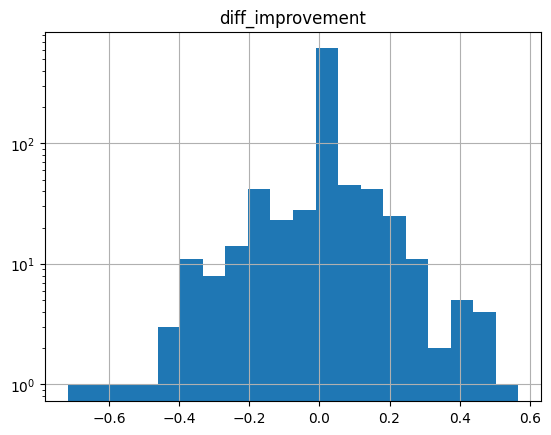

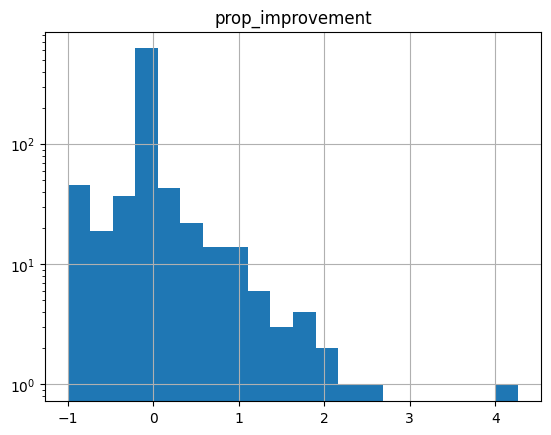

In [102]:
eval.hist(column="diff_improvement", bins=20, log=[True, False])
eval[eval["prop_improvement"] != float('inf')].hist(column="prop_improvement", bins=20, log=[True, False])

In [103]:
# average diff_improvement
eval[["is_long", "diff_improvement"]].groupby("is_long").mean()

,diff_improvement
is_long,
False,-0.008116
True,0.009904


In [104]:
# total diff_improvement
eval[["is_long", "diff_improvement"]].groupby("is_long").sum()

,diff_improvement
is_long,
False,-3.72516
True,4.18945
